# 使用lstm预测

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 2. 准备数据

In [2]:
train_df = gpd.read_file("/input/covid19-global-forecasting-week-4/train.csv")
train_df["ConfirmedCases"] = train_df["ConfirmedCases"].astype("float")
train_df["Fatalities"] = train_df["Fatalities"].astype("float")

train_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in train_df.iterrows()]

In [3]:

extra_data_df = gpd.read_file("/input/enriched-covid-19-week2/enriched_covid_19_week_2.csv")
extra_data_df["Country_Region"] = [country_name.replace("'","") for country_name in extra_data_df["Country_Region"]]
extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
extra_data_df["density"] = extra_data_df["density"].astype("float")
extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
extra_data_df["lung"] = extra_data_df["lung"].astype("float")
extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

extra_data_df = extra_data_df[["Country_Region","Date","restrictions","quarantine","schools","hospibed","lung","total_pop","density","age_100+"]]
extra_data_df.head()

,Country_Region,Date,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,Afghanistan,2020-01-22,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
1,Afghanistan,2020-01-23,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
2,Afghanistan,2020-01-24,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
3,Afghanistan,2020-01-25,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
4,Afghanistan,2020-01-26,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411


In [4]:
train_df = train_df.merge(extra_data_df, how="left", on=['Country_Region','Date']).drop_duplicates()
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411


In [5]:
for country_region in train_df.Country_Region.unique():
    query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]

In [6]:
median_pop = np.median(extra_data_df.total_pop)
median_hospibed = np.median(extra_data_df.hospibed)
median_density = np.median(extra_data_df.density)
median_lung = np.median(extra_data_df.lung)
median_centenarian_pop = np.median(extra_data_df["age_100+"])

print("The missing countries/region are:")
for country_region in train_df.Country_Region.unique():
    if extra_data_df.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        train_df.loc[train_df["Country_Region"]==country_region,"total_pop"] = median_pop
        train_df.loc[train_df["Country_Region"]==country_region,"hospibed"] = median_hospibed
        train_df.loc[train_df["Country_Region"]==country_region,"density"] = median_density
        train_df.loc[train_df["Country_Region"]==country_region,"lung"] = median_lung
        train_df.loc[train_df["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        train_df.loc[train_df["Country_Region"]==country_region,"restrictions"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"quarantine"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"schools"] = 0

The missing countries/region are:
Botswana
Burma
Burundi
Canada_Northwest Territories
Canada_Yukon
France_Saint Pierre and Miquelon
Kosovo
MS Zaandam
Malawi
Netherlands_Bonaire, Sint Eustatius and Saba
Sao Tome and Principe
Sierra Leone
South Sudan
United Kingdom_Anguilla
United Kingdom_British Virgin Islands
United Kingdom_Falkland Islands (Malvinas)
United Kingdom_Turks and Caicos Islands
West Bank and Gaza
Western Sahara


In [7]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [8]:
#构造序列
train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
days_in_sequence = 21

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            

            for i in range(0,len(province_df),int(days_in_sequence/3)):
                if i+days_in_sequence<=len(province_df):

                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]


                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)
                    centenarian_pop = float(province_df.iloc[i]["age_100+"])

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 313/313 [00:16<00:00, 18.77it/s]


Preparing the inputs and shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [9]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [10]:
trend_df.head()

,infection_trend,fatality_trend,restriction_trend,quarantine_trend,school_trend,demographic_inputs,expected_cases,expected_fatalities,temporal_inputs
2099,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.025933259892085968, 0.003607092683297262, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.026294712616898665, 0.004708205186619584, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00012758005065787237, 0.011428788396552378,...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1900,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
534,"[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.003607092683297262, 0.1956521739130435...",18.0,0.0,"[[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18..."


In [11]:
i=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<25:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [12]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
2099,"[0.025933259892085968, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1400,"[0.026294712616898665, 0.004708205186619584, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1451,"[0.00012758005065787237, 0.011428788396552378,...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1900,"[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
534,"[1.0, 0.003607092683297262, 0.1956521739130435...",18.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18..."


# 划分训练集

In [13]:
sequence_length = 20
training_percentage = 0.9

In [14]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [15]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [16]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length)),(0,2,1)) ).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

# 3. 构造模型

In [17]:

temporal_input_layer = Input(shape=(sequence_length,5))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)


demographic_input_layer = Input(shape=(5))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)


rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           96          input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [19]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 975 samples, validate on 109 samples
Epoch 1/250
975/975 [==============================] - 9s 9ms/sample - loss: 10.6014 - cases_loss: 9.1545 - fatalities_loss: 1.4393 - val_loss: 4.8438 - val_cases_loss: 3.9771 - val_fatalities_loss: 0.8372
Epoch 2/250
975/975 [==============================] - 2s 2ms/sample - loss: 5.0408 - cases_loss: 3.9627 - fatalities_loss: 1.0756 - val_loss: 3.1688 - val_cases_loss: 2.4836 - val_fatalities_loss: 0.6586
Epoch 3/250
975/975 [==============================] - 2s 2ms/sample - loss: 3.5641 - cases_loss: 2.8420 - fatalities_loss: 0.7206 - val_loss: 2.2247 - val_cases_loss: 1.8413 - val_fatalities_loss: 0.3620
Epoch 4/250
975/975 [==============================] - 2s 2ms/sample - loss: 2.8321 - cases_loss: 2.3003 - fatalities_loss: 0.5304 - val_loss: 1.7760 - val_cases_loss: 1.4858 - val_fatalities_loss: 0.2718
Epoch 5/250
975/975 [==============================] - 2s 2ms/sample - loss: 2.4104 - cases_loss: 1.9618 - fatalities_loss: 0.4468 - 

# 4. 模型评估

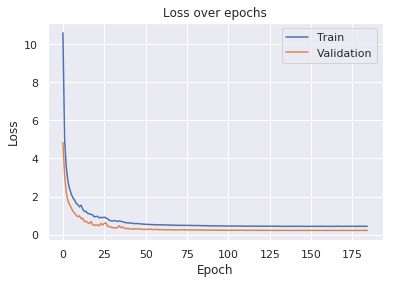

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

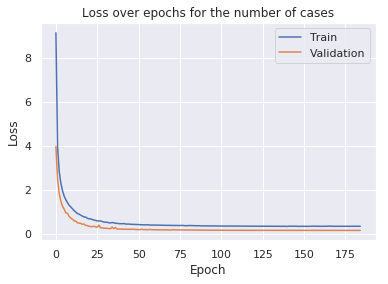

In [21]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

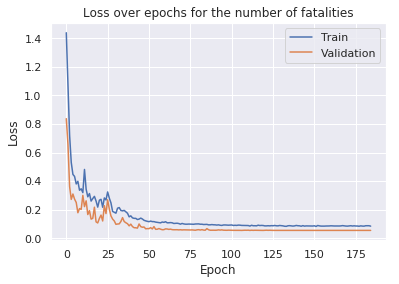

In [22]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. 预测

In [23]:
model.load_weights("best_model.h5")

In [24]:
predictions = model.predict([X_temporal_test,X_demographic_test])

In [25]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0.]]
Expected cases: 4.0  Prediction: 3.9486732 Expected fatalities: 0.0  Prediction: -0.12751679
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  1.]
 [ 5.  0.  1.  0.  1.]
 [ 5.  0.  1.  0.  1.]
 [ 6.  0.  1.  0.  1.]
 [ 6.  0.  1.  0.  1.]
 [ 6.  0.  1.  0.  1.]
 [ 8.  0.  1.  0.  1.]
 [ 9.  0.  1.  0.  1.]
 [11.  0.  1.  0.  1.]
 [11.  0.  1.  0.  1.]
 [13.  0.  1.  0.  1.]
 [18.  1.  1.  0.  1.]
 [22.  1.  1.  0.  1.]
 [22.  1.  1.  0.  1.]
 [27.  2.  1.  0.  1.]]
Expected cases: 37.0  Prediction: 36.152664 Expected fatalities: 3.0  Prediction: 3.0

In [26]:

def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=20)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    

    temporal_input_data = np.transpose(np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)), (1,0) ).astype(np.float32)
    

    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    hospibed = float(province_df.iloc[i].hospibed)
    lung = float(province_df.iloc[i].lung)
    centenarian_pop = float(province_df.iloc[i]["age_100+"])
    demographic_input_data = [total_population,density,hospibed,lung,centenarian_pop]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [27]:

def predict_for_region(country, province, df):
    begin_prediction = "2020-04-01"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-14"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        

        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        

        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "age_100+": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [28]:

copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

100%|██████████| 313/313 [31:21<00:00,  6.01s/it]


# 6.四月数据误差计算

In [29]:
groundtruth_df = gpd.read_file("/input/covid19-global-forecasting-week-4/train.csv")

groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")

groundtruth_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in groundtruth_df.iterrows()]

last_date = groundtruth_df.Date.unique()[-1]

In [30]:

pd.options.mode.chained_assignment = None

def get_RMSLE_per_region(region, groundtruth_df, display_only=False):
    groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
    groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
    

    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    predictions = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    
    RMSLE_cases = np.sqrt(mean_squared_log_error( groundtruth.ConfirmedCases.values, predictions.ConfirmedCases.values ))
    RMSLE_fatalities = np.sqrt(mean_squared_log_error( groundtruth.Fatalities.values, predictions.Fatalities.values ))
    
    if display_only:
        print(region)
        print("RMSLE on cases:",np.mean(RMSLE_cases))
        print("RMSLE on fatalities:",np.mean(RMSLE_fatalities))
    else:
        return RMSLE_cases, RMSLE_fatalities

In [31]:
def get_RMSLE_for_all_regions(groundtruth_df):
    RMSLE_cases_list = []
    RMSLE_fatalities_list = []
    for region in groundtruth_df.Country_Region.unique():
        RMSLE_cases, RMSLE_fatalities = get_RMSLE_per_region(region, groundtruth_df, False)
        RMSLE_cases_list.append(RMSLE_cases)
        RMSLE_fatalities_list.append(RMSLE_fatalities)
    print("RMSLE on cases:",np.mean(RMSLE_cases_list))
    print("RMSLE on fatalities:",np.mean(RMSLE_fatalities_list))

In [32]:
get_RMSLE_for_all_regions(groundtruth_df)

RMSLE on cases: 0.49494465612276073
RMSLE on fatalities: 0.3770080063743591


In [33]:
badly_affected_countries = ["France","Italy","United Kingdom","Spain","Iran","Germany"]
for country in badly_affected_countries:
    get_RMSLE_per_region(country, groundtruth_df, display_only=True)

France
RMSLE on cases: 0.6055889849865056
RMSLE on fatalities: 0.917603893928617
Italy
RMSLE on cases: 0.21993188939467181
RMSLE on fatalities: 0.2790982583478945
United Kingdom
RMSLE on cases: 0.7023263322485703
RMSLE on fatalities: 1.0985807570598574
Spain
RMSLE on cases: 0.3452272671599796
RMSLE on fatalities: 0.4424718447195897
Iran
RMSLE on cases: 0.2918973895938459
RMSLE on fatalities: 0.24915402316605503
Germany
RMSLE on cases: 0.36357028547960063
RMSLE on fatalities: 0.8511859973565415
